# Data Analytics Project
## Prediction and analysis of marital status of people in USA over the years

Authors: Julia Nowak, Adam Złocki

### 1. Problem Statement


##### Main problem
The goal of the project is to predict the number of adult married individuals in the U.S. society. The problem does not focus on specific races - general data common to all races has been accepted. However, the selected dataset allows for dividing the data into specific races and separate analysis of marital status. The idea of the project is based on the current topic concerning the hypothetical decline in the number of marriages and the increase in the number of divorces in highly developed countries such as the USA. During the analysis, we want to demonstrate existing trends and predict the distribution of the values we are interested in for the future.

##### Examples of use and reasons for analysis
The problem of predicting marital status and the number of marriages in society is extremely important information from the government's perspective. This is a problem worth analyzing, especially for planning the U.S. government's family policy. The topic is also significant for all types of estimates related to natural population growth or social conditions. The analysis can provide the government with early indications of certain changes occurring in society, which should be considered when creating future plans.

##### Data origin and content
The data we are using comes from the official U.S. government website (www.census.gov). It includes information on the number of people with a given marital status by year, the average age of first marriage, the number of households, and the overall average income per household member to present the general economic situation of the society.

Additionally, the data is available with a division by race, allowing for predictions for each race separately and subsequent comparative analysis, although we did not adopt this approach. The data we use is historical, spanning from the 20th century to 2023, with the latest update in November 2023, making it relatively recent. For the analysis, we used the years 1993-2023, excluding duplicates of some years (choosing the most recent data from each pair).

The data includes various tables from the Current Population Survey (CPS), conducted annually by the U.S. Census Bureau.

##### Data explanation
In our dataset we have six columns:
- Year - the year in which the data was collected,
- Married - number of people married in a given year (in thousands),
- Income per member - average income per household member in a given year,
- Mean age - the average age of entering into first marriage in a given year,
- Household - number of households in a given year,
- Total - total population (in thousands)

##### DAG Diagram
The following DAG diagram represents the dependencies utilized in our project. For our predictions, we applied average household income per member and the number of households, allowing us to examine the impact of the overall economic situation of society on the number of marriages. Additionally, we also took into account the average age of first marriage.


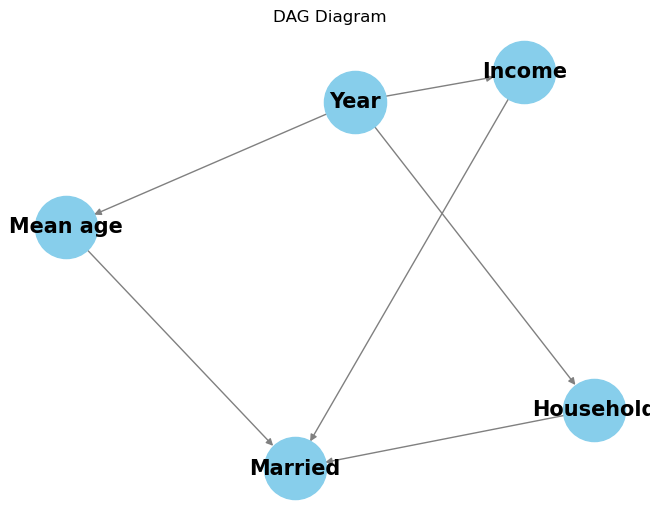

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Mean age")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Household")
G.add_edge("Year", "Income")
G.add_edge("Year", "Mean age")


G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("DAG Diagram")
plt.show()


COLLIDERS - In a path that is an inverted fork (x -> m <- y), the node where two or more arrowheads meet is called a collider (because the paths collide there). An inverted fork is not an open path:

Household -> Married \
Mean age -> Married \
Income -> Married 



Fork: Example: A ← B ← C → D → E. Variable C forks into two chains, C → B → A and C → D → E.

FORKS: \
Year -> Mean age -> Married \
Year -> Household -> Married \
Year -> Income -> Married


The data can be represented differently based on the way of thinking. All our columns are higly correlated and it means that they all might have influence on each other.

### 2. Data Preprocessing

1. Selection of Analyzed Years and Races:

- Years 1993-2022 were chosen for analysis (almost 30 years of data).
- Years 2018-2023 were set aside for model evaluation.
- The focus was on analyzing overall data across all races combined.

2. Data Notes:

- In years 2011 and 2021, the data included duplicate results due to presenting both original and updated values based on the latest decennial population census (updated values were adopted).
- In 2014, there was a change in income-related survey questions, resulting in differences in questions asked to respondents.
- Since 2019, same-sex marriages have also been included.

3. Cleaning and Operations:

- Year format was changed from "..2011" to a format without dots.
- Year 2023 was excluded due to income data being from previous years.
- Duplicate years were removed.
- Data was merged to omit gender considerations.
- Total respondents were calculated (including data beyond the analyzed period).
- Household data was selected from a separate database for improved results.
- Years were transformed into numbers and data types were standardized.


##### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
warnings.filterwarnings('ignore')

##### Reading data from a concatenated file

In [4]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Data splitting

In [5]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Preliminary data analysis

In [6]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [7]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household,Total
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000,265193.600000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866,2669.521923
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000,262058.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000,263457.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000,264696.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000,267174.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


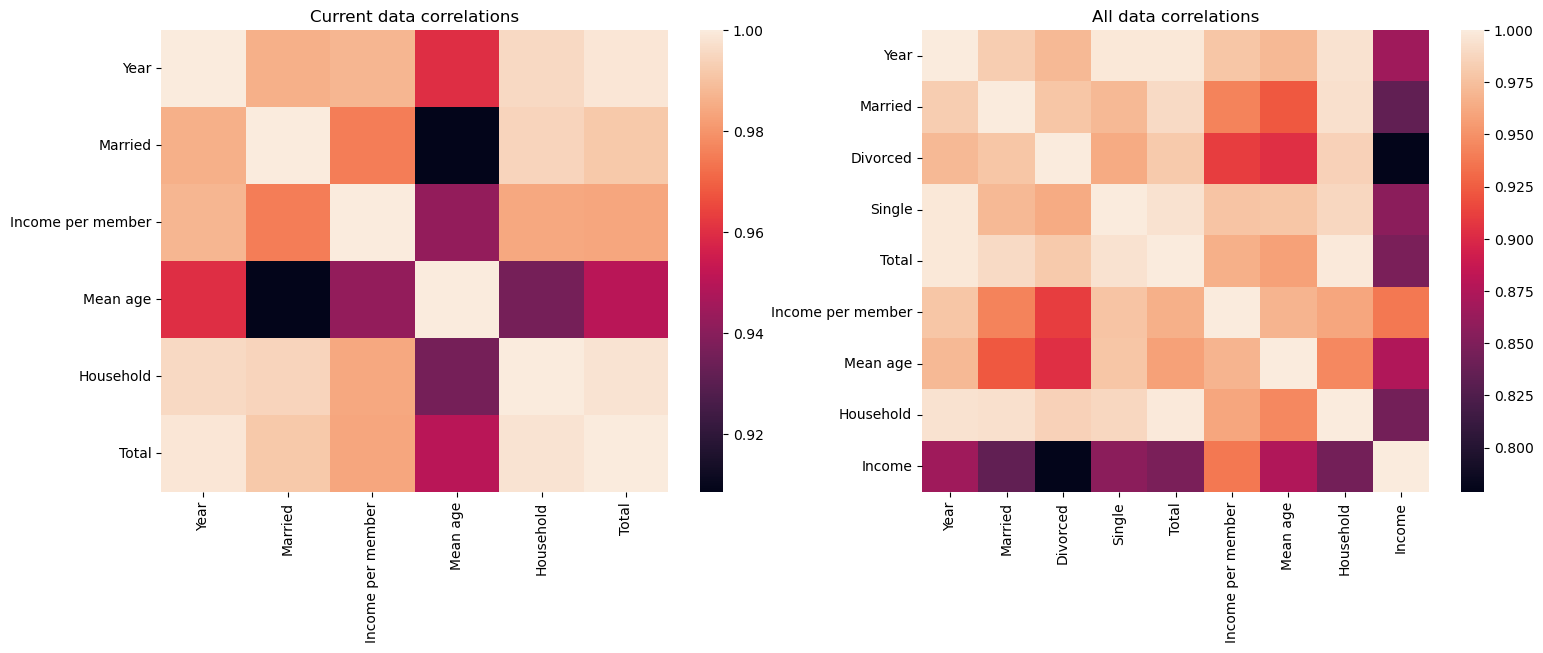

In [8]:
# Correlations

fig, ax = plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Current data correlations')
sns.heatmap(df.corr(method="pearson"), ax=ax[0])

ax[1].set_title('All data correlations')
sns.heatmap(df_ac.corr(method="pearson"), ax=ax[1])

plt.show()


##### Notice
The data we selected are strongly correlated with each other (over 90% correlation). High correlation typically means values in one column can be predicted from another, suggesting redundancy or collinearity. It is recommended to avoid having correlated features in your dataset. Indeed, a group of highly correlated features will not bring additional information (or just very few), but will increase the complexity of the algorithm, thus increasing the risk of errors.
Using highly correlated predictors in techniques like linear regression can result in highly unstable models, numerical errors, and very poor prediction performance.

Solution: Remove Redundant Predictors (doesn't make sense)
- Principal Component Analysis (PCA)

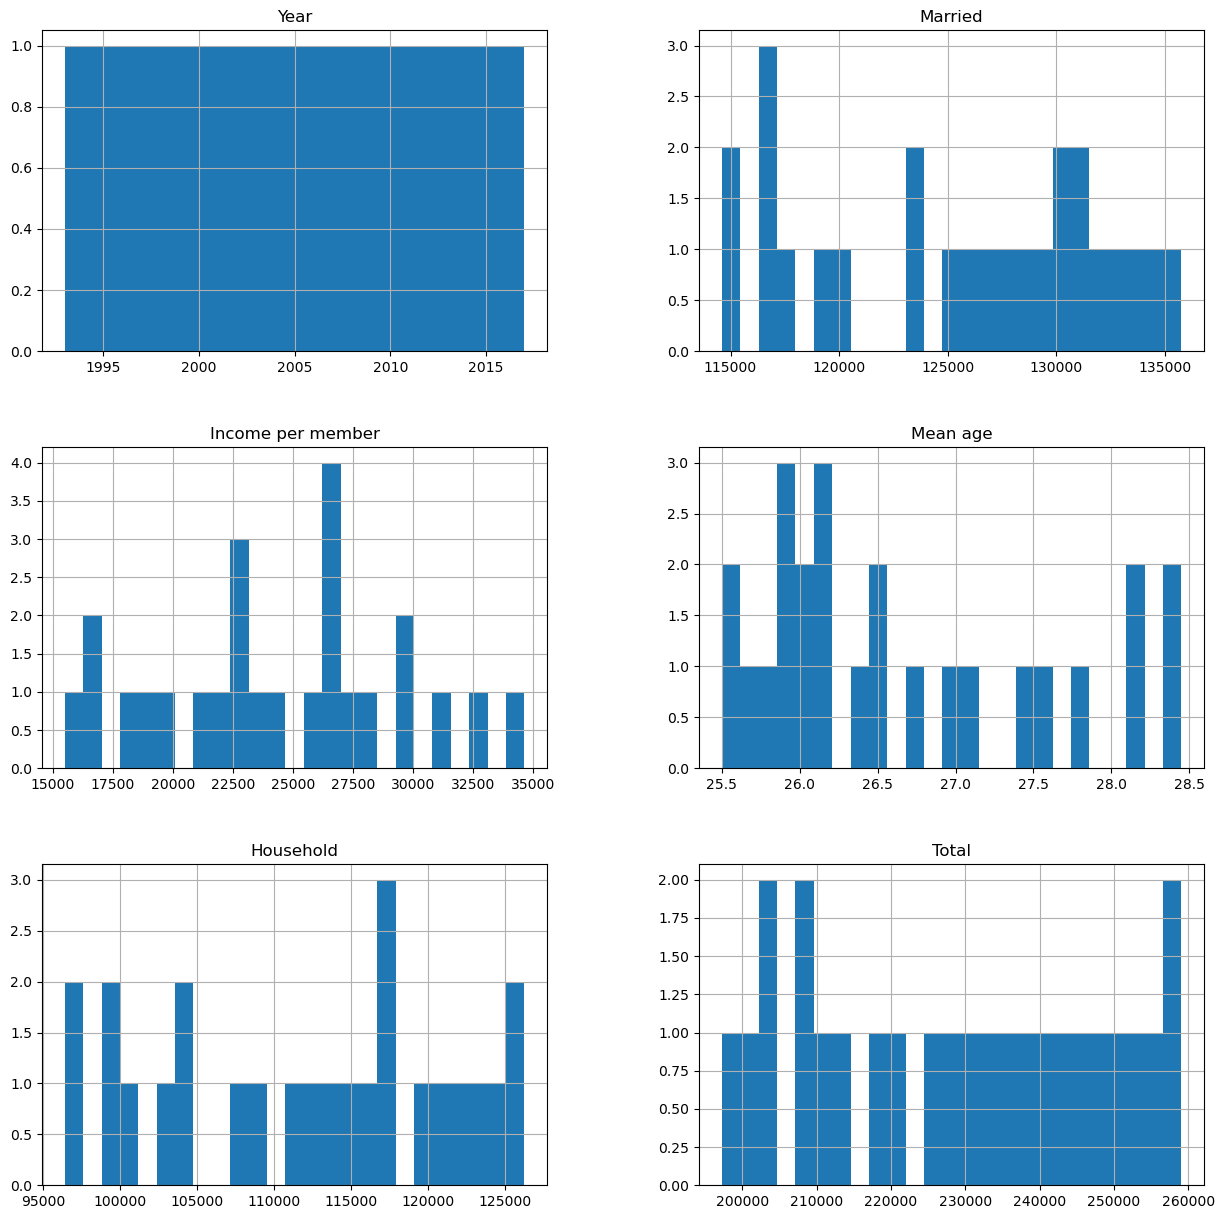

In [9]:
# Data overview
df.hist(figsize=(15,15), bins=25)
plt.show()

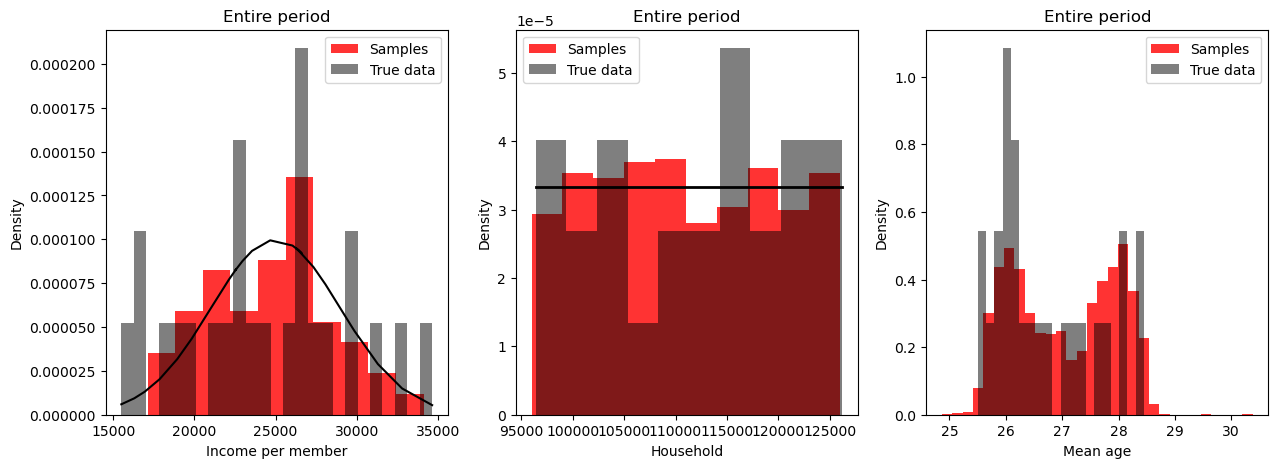

In [91]:
# Histograms of data

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sim = random.normal(25000, 4000, 100) # mu, sigma, samples
plt.plot(df['Income per member'], stats.norm.pdf(df['Income per member'], 25000, 4000), c='k')
plt.hist(sim, color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Income per member'], color='black',bins=25, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Income per member')
plt.legend()

plt.subplot(1,3,2)
sim = random.uniform(96000, 126000, 1000) # a - from, b - to, samples
# 1/(a-b) - height
plt.plot(df['Household'], [1/(126000-96000)]*len(df['Household']), linewidth=2, color='k')
plt.hist(sim, color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Household'], color='black',bins=10, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()

plt.subplot(1,3,3)
sim = random.uniform(96000, 126000, 1000)
s = np.random.lognormal(0.15, 0.38, 1000) + 25
d = -np.random.lognormal(0.09, 0.4, 1000)+ 29

X = np.concatenate([s,d])
plt.hist(X, color='red', alpha = 0.8, density=True, bins=30, label="Samples")
plt.hist(df['Mean age'], color='black', bins=20, alpha = 0.5, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()
plt.show()

### 3. Model creation

We have created two models: 
- the first model predicts the number of individuals after marriage based on data about average household income per member, 
- the second model additionally utilizes the number of households and the average age of entering first marriage.

We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model 1:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- Linear equation: f(income) = $\alpha$*income + $\beta$
- Sampling: y(income) = NORMAL(f(income), $\sigma$)

Model 2:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of households, average age of first marriage
- Linear equation: f(income, household, age) = $\alpha_1$*income + $\alpha_2$*household + $\alpha_3$*age + $\beta$
- Sampling: y(income) = NORMAL(f(income, household, age), $\sigma$)




##### Differences
Despite highly correlated features, adding additional parameters makes sense as it complicates the equation but does not significantly impact the prediction. The impact is smaller, but the difference is noticeable.

In [2]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

14:18:16 - cmdstanpy - INFO - compiling stan file C:\Users\adamz\Desktop\Data Analitics\DA_project\prior.stan to exe file C:\Users\adamz\Desktop\Data Analitics\DA_project\prior.exe
14:19:08 - cmdstanpy - INFO - compiled model executable: C:\Users\adamz\Desktop\Data Analitics\DA_project\prior.exe
14:19:09 - cmdstanpy - INFO - compiling stan file C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_prior.stan to exe file C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_prior.exe
14:19:28 - cmdstanpy - INFO - compiled model executable: C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_prior.exe


### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

##### Prior selection
We have chosen following priors for both of our models:
- For model 1.:
    * $\alpha$ ∼ Normal(1.26, 0.04), 
    * $\beta$ ∼ Normal(94800, 2000), 
- For model 2.:
    * $\alpha_1$ ∼ Normal(0.012, 0.001),
    * $\alpha_2$ ∼ Normal(0.81, 0.01),
    * $\alpha_3$ ∼ Normal(1280, 20), 
    * $\beta$ ∼ Normal(68500, 2000),

##### Prior parameters selection
The prior parameters were chosen by fitting a function that closely resembled the trend of marriages over the years. In this case, it turned out to be a linear function (for the first model) or closely approximated a linear function within this range (for the second model).

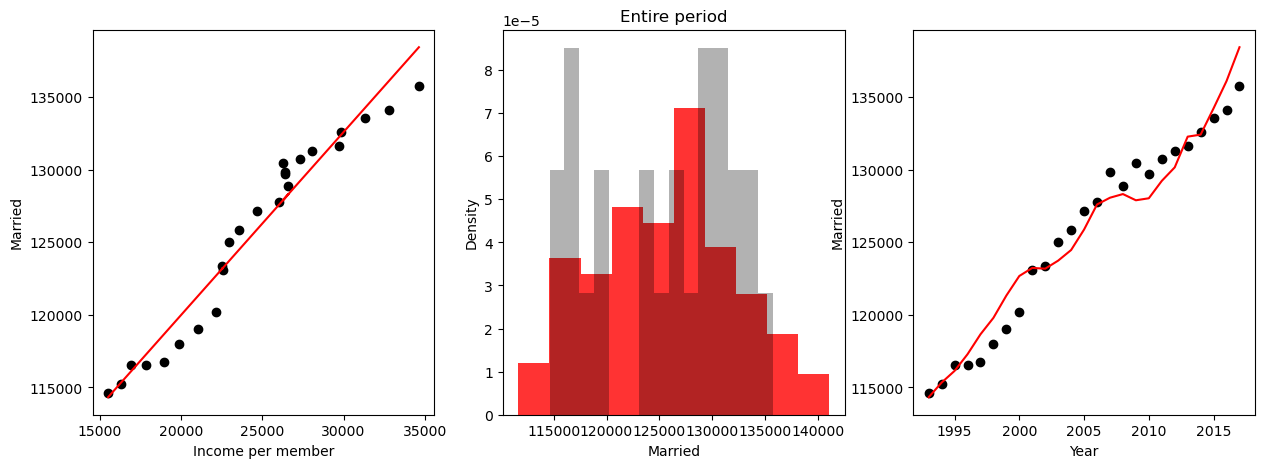

In [10]:
# Parameters testing for Model 1

A = np.vstack([df['Income per member'], np.ones(len(df['Income per member']))]).T

# Parameter match - function modelling
a, b = np.linalg.lstsq(A, df['Married'], rcond=None)[0]

# Best selection of parameters
alpha = 1.26
beta = 94800
sigma = 1000

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df['Income per member'], df['Married'], color='black')
plt.plot(df['Income per member'], alpha*df['Income per member'] + beta, color='red')
plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(1,3,2)
sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))

plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True)

plt.hist(df['Married'], color='black',bins=15, alpha = 0.3, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')

plt.subplot(1,3,3)
plt.scatter(df['Year'], df['Married'], color='black')
plt.plot(df['Year'], alpha*df['Income per member'] + beta, color='red')
plt.xlabel('Year')
plt.ylabel('Married')

plt.show()

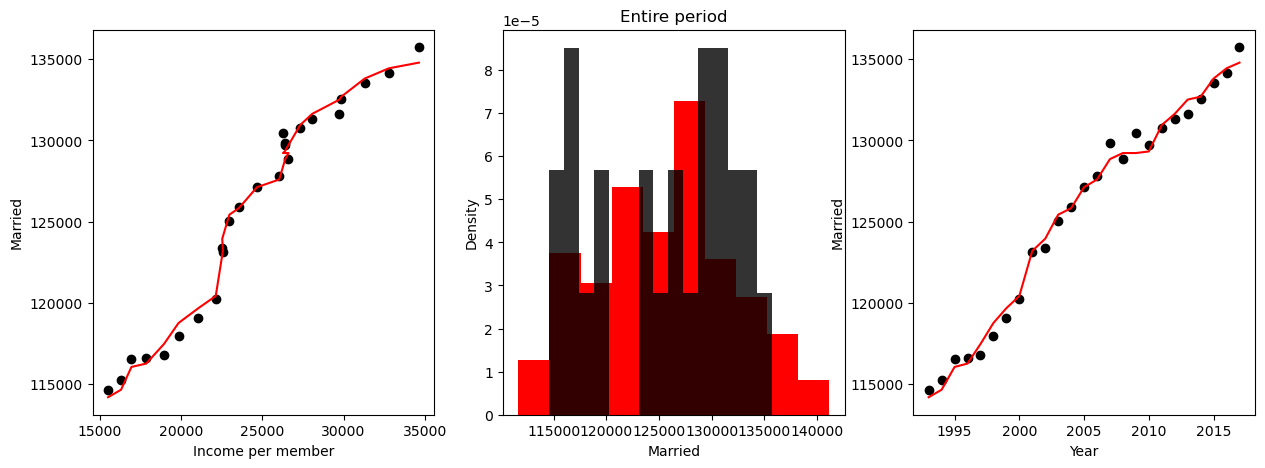

In [94]:
# Parameters testing for Model 2

# Sample data
x = df['Income per member']
y = df['Household']
z = df['Mean age']

c = df['Married']

X = np.column_stack((np.ones_like(x), x, y, z))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, c, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y, slope_z = coefficients

# Define points for the plane
z_plane = slope_x * x + slope_y * y + slope_z * z + intercept 

intercept, slope_x, slope_y, slope_z


plt.figure(figsize=(15,5))


plt.subplot(1,3,1)
plt.scatter(df['Income per member'], df['Married'], color="black")
plt.plot(df['Income per member'], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(1,3,2)
sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))

for i in range(len(sim)):
    plt.hist(sim.flatten().tolist(), color='red', alpha = 0.3, density=True)

plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')


plt.subplot(1,3,3)
plt.scatter(df["Year"], df['Married'], color="black")
plt.plot(df["Year"], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red")
plt.xlabel('Year')
plt.ylabel('Married')


plt.show()

#### 4.1. Model 1.

In [19]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=1000,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

15:08:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:08:58 - cmdstanpy - INFO - CmdStan done processing.


In [20]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,363.866,117641.0,118205.0,119694.0,121310.0,123219.0,...,133201.0,132597.0,132819.0,134335.0,135459.0,137393.0,137668.0,139021.0,141757.0,144066.0
1,0.0,0.0,1.31904,94585.6,920.009,115618.0,116481.0,114319.0,119083.0,120051.0,...,129924.0,127965.0,128886.0,130385.0,132314.0,134090.0,134564.0,134769.0,137831.0,140274.0
2,0.0,0.0,1.32074,95939.3,1369.850,118025.0,119129.0,119395.0,120566.0,118716.0,...,129258.0,131617.0,133192.0,131577.0,130381.0,135740.0,135535.0,135992.0,140704.0,141658.0
3,0.0,0.0,1.27851,93917.6,1448.920,114407.0,113572.0,115352.0,113999.0,116686.0,...,126430.0,127360.0,129535.0,128749.0,129187.0,130304.0,130324.0,135987.0,135567.0,137973.0
4,0.0,0.0,1.29026,95390.9,1441.340,112325.0,116740.0,113999.0,117546.0,118565.0,...,128488.0,129924.0,130377.0,131357.0,129797.0,135208.0,134845.0,134200.0,139138.0,140197.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.27123,98553.1,1092.060,118179.0,117120.0,119892.0,120294.0,122891.0,...,132883.0,133418.0,131684.0,131831.0,134899.0,135418.0,137114.0,137796.0,140630.0,142907.0
996,0.0,0.0,1.33231,93941.8,1098.580,114304.0,114877.0,117807.0,118076.0,119306.0,...,129902.0,128378.0,130211.0,130287.0,130697.0,132833.0,131028.0,134417.0,138233.0,139323.0
997,0.0,0.0,1.23141,95651.1,796.777,112963.0,115585.0,116849.0,117435.0,118604.0,...,128520.0,127847.0,126671.0,128202.0,129866.0,132308.0,132206.0,133475.0,134848.0,137624.0
998,0.0,0.0,1.37256,94020.4,1494.500,115418.0,116485.0,118237.0,117608.0,118908.0,...,130368.0,132500.0,130404.0,130050.0,135787.0,134952.0,131668.0,137241.0,141487.0,141059.0


##### Prior predictive checks for parameters

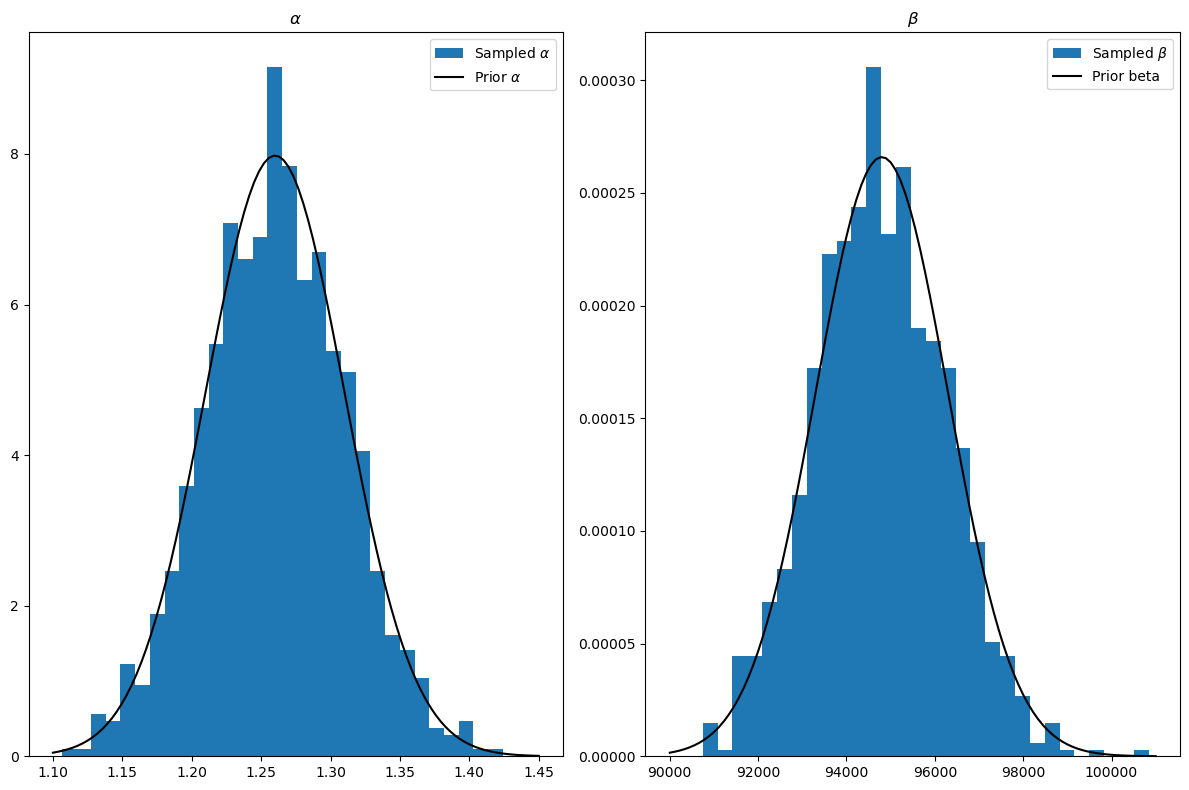

In [21]:
alpha_pred = prior_1.stan_variable('alpha')
beta_pred= prior_1.stan_variable('beta')

fig,axes = plt.subplots(1,2,figsize = (12,8), tight_layout=True)
x = np.linspace(1.1,1.45,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.05)
axes[0].hist(alpha_pred, bins=30,label=r'Sampled $\alpha$',density=True)
axes[0].set_title(r'$\alpha$')
axes[0].plot(x,y,label=r'Prior $\alpha$',color='k')
axes[0].legend()

x = np.linspace(90000, 101000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=1500)
axes[1].hist(beta_pred, bins=30,label=r'Sampled $\beta$',density=True)
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = 'Prior beta',color='k')
axes[1].legend()
plt.show()

##### Prior predictive checks for measurements

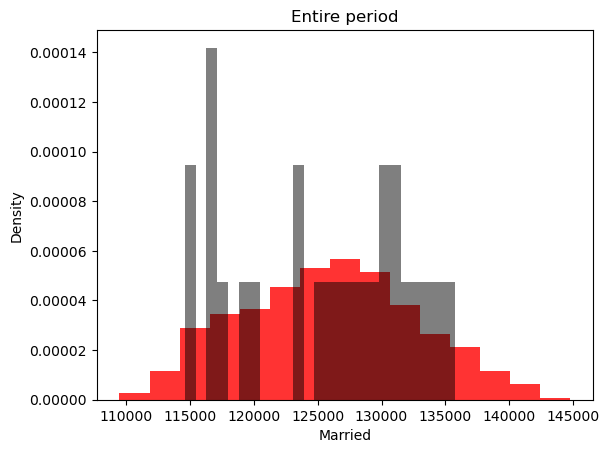

In [98]:
plt.hist(prior_1.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

#### 4.2. Model 2.

In [15]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

14:22:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

14:22:12 - cmdstanpy - INFO - CmdStan done processing.


In [16]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.014708,0.817772,1254.55,68755.2,30.5289,115825.0,116326.0,117783.0,...,131093.0,131115.0,131229.0,132848.0,133564.0,134408.0,134655.0,135764.0,136473.0,136791.0
1,0.0,0.0,0.011840,0.816388,1288.60,62824.4,151.7530,108921.0,109444.0,110657.0,...,124126.0,124052.0,124206.0,125565.0,126442.0,127327.0,127691.0,128748.0,129381.0,129800.0
2,0.0,0.0,0.013213,0.817903,1295.36,65232.6,213.5020,111550.0,111545.0,113237.0,...,126475.0,126247.0,126774.0,128185.0,128966.0,129649.0,130144.0,131181.0,131546.0,132043.0
3,0.0,0.0,0.010109,0.800013,1304.34,66800.5,85.4239,110869.0,111489.0,112641.0,...,125590.0,125581.0,125738.0,127315.0,128029.0,128628.0,128989.0,129878.0,130628.0,130948.0
4,0.0,0.0,0.012259,0.794668,1259.70,70734.9,75.3730,115375.0,115772.0,117214.0,...,130157.0,130192.0,130350.0,131875.0,132475.0,133480.0,133521.0,134659.0,135296.0,135759.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.010789,0.799298,1277.12,66982.7,130.9510,111696.0,112137.0,113748.0,...,126652.0,126402.0,126390.0,128281.0,128886.0,129672.0,129624.0,130905.0,131740.0,131847.0
96,0.0,0.0,0.012588,0.813148,1287.05,69854.7,173.8200,115592.0,116273.0,117584.0,...,130752.0,131016.0,130790.0,132424.0,133237.0,133995.0,134051.0,135283.0,136125.0,136335.0
97,0.0,0.0,0.013253,0.812071,1244.70,68002.4,17.0457,114736.0,115226.0,116606.0,...,129870.0,129919.0,130029.0,131646.0,132327.0,133246.0,133442.0,134560.0,135188.0,135601.0
98,0.0,0.0,0.011151,0.806342,1310.00,63997.8,129.9900,108454.0,108792.0,110407.0,...,123358.0,123377.0,123584.0,125314.0,126066.0,126668.0,126864.0,128147.0,128654.0,128956.0


##### Prior predictive checks for parameters

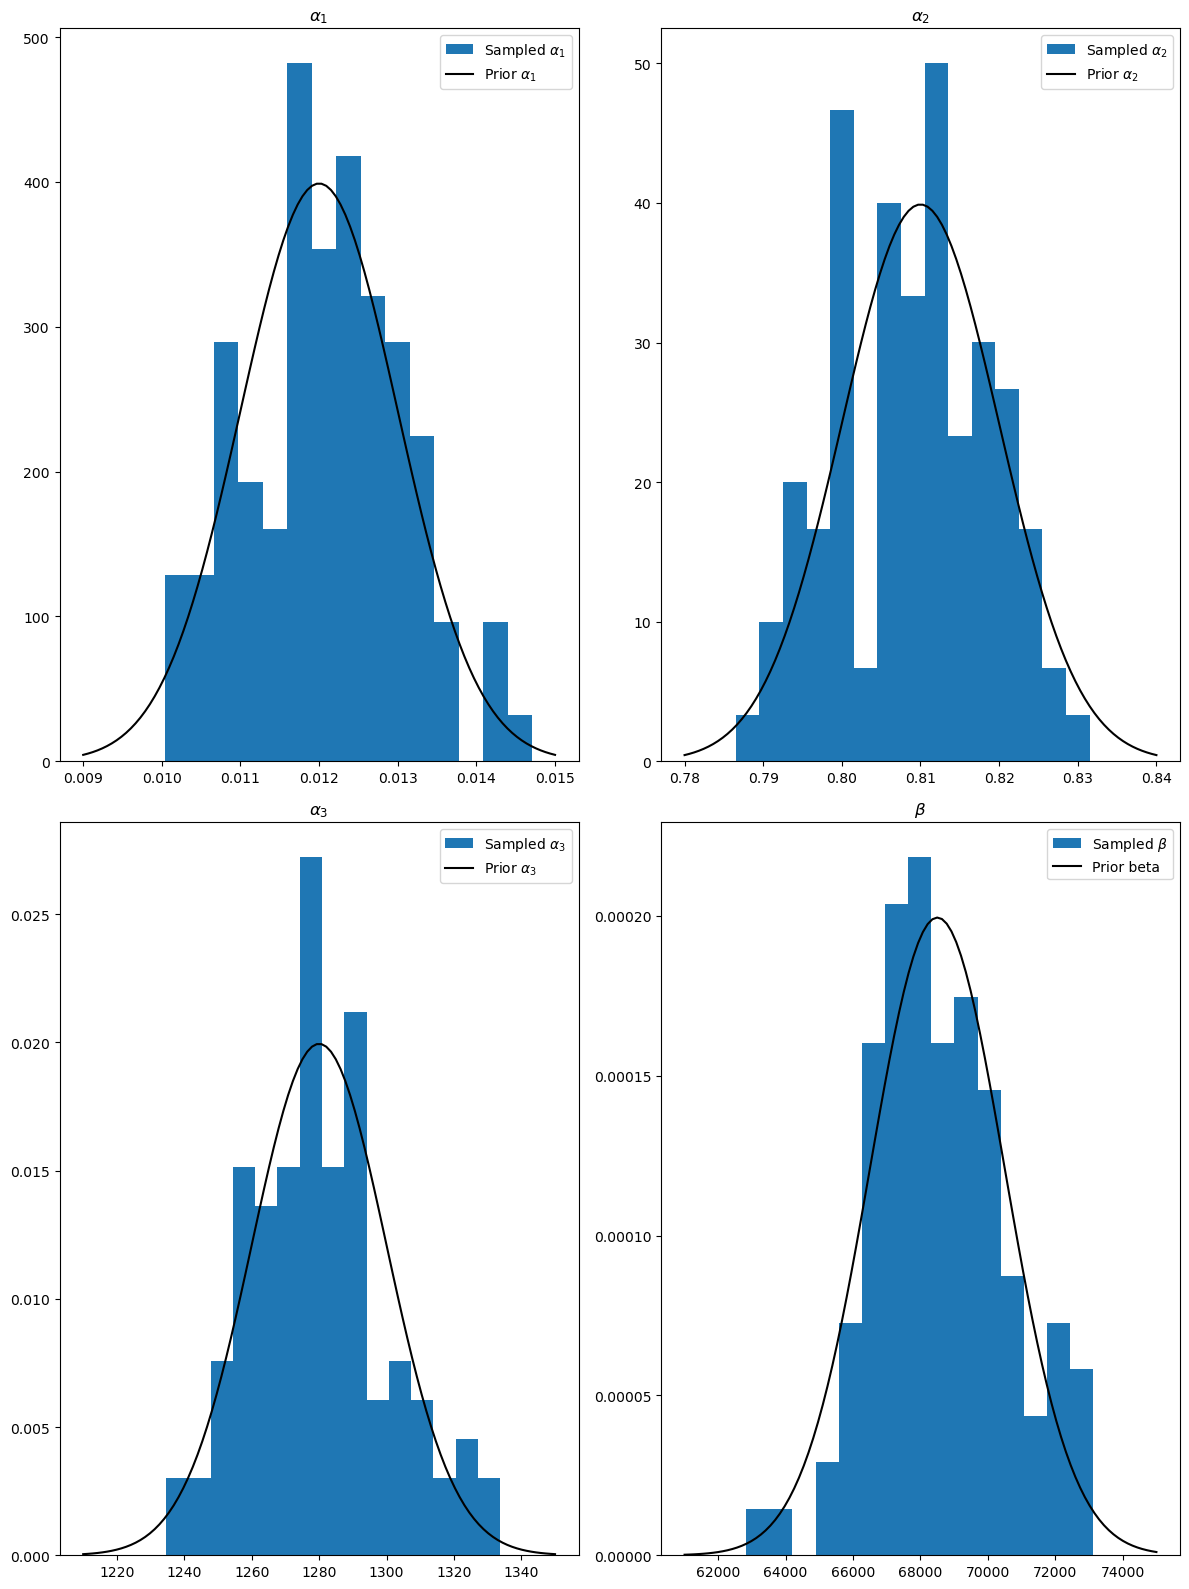

In [87]:
alpha1_pred = prior_2.stan_variable('alpha_1')
alpha2_pred = prior_2.stan_variable('alpha_2')
alpha3_pred = prior_2.stan_variable('alpha_3')
beta_pred= prior_2.stan_variable('beta')

fig,axes = plt.subplots(2,2,figsize = (12,16), tight_layout=True)
x = np.linspace(0.009,0.015,100)
y = stats.norm.pdf(x=x,loc=0.012, scale=0.001)
axes[0][0].hist(alpha1_pred, bins=15,label=r'Sampled $\alpha_1$',density=True)
axes[0][0].set_title(r'$\alpha_1$')
axes[0][0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0][0].legend()

x = np.linspace(0.78,0.84,100)
y = stats.norm.pdf(x=x,loc=0.81, scale=0.01)
axes[0][1].hist(alpha2_pred, bins=15,label=r'Sampled $\alpha_2$',density=True)
axes[0][1].set_title(r'$\alpha_2$')
axes[0][1].plot(x,y,label=r'Prior $\alpha_2$',color='k')
axes[0][1].legend()

x = np.linspace(1210,1350,100)
y = stats.norm.pdf(x=x,loc=1280, scale=20)
axes[1][0].hist(alpha3_pred, bins=15,label=r'Sampled $\alpha_3$',density=True)
axes[1][0].set_title(r'$\alpha_3$')
axes[1][0].plot(x,y,label=r'Prior $\alpha_3$',color='k')
axes[1][0].legend()

x = np.linspace(61000, 75000, 100)
y = stats.norm.pdf(x=x,loc=68500, scale=2000)
axes[1][1].hist(beta_pred, bins=15,label=r'Sampled $\beta$',density=True)
axes[1][1].set_title(r'$\beta$')
axes[1][1].plot(x,y,label = 'Prior beta',color='k')
axes[1][1].legend()
plt.show()

##### Prior predictive checks for measurements

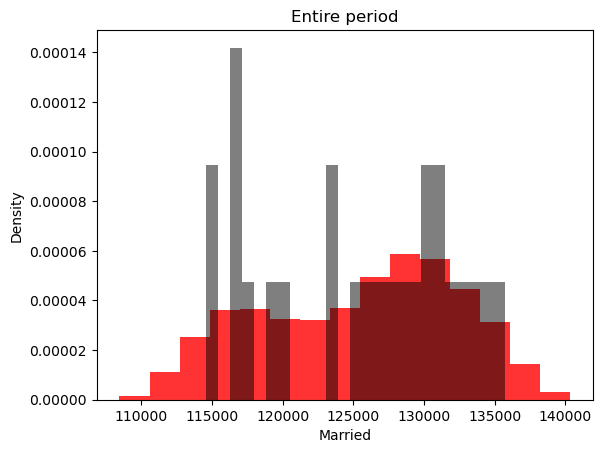

In [102]:
prior_2_combined = []
for i in range(R):
    prior_2_combined.extend(prior_2.y_sim[i])
plt.hist(prior_2_combined, bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

### 5. Posterior (model 1) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [103]:
data = {'N': N, 'income': df['Income per member'], 'y': df['Married']}
post_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=100)

13:59:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


13:59:25 - cmdstanpy - INFO - CmdStan done processing.


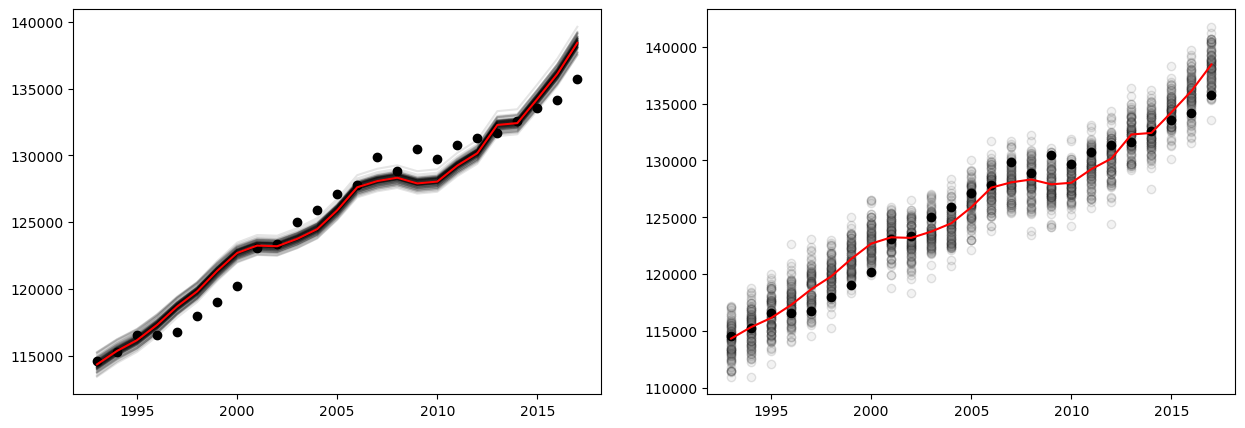

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_1.y_sim)):
    plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_1.y_sim)):
    plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [105]:
post_1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-189.04000,0.170417,1.146830,-191.17300,-188.70900,-187.83400,45.2867,5660.84,0.992361
alpha,1.25865,0.003506,0.027273,1.20359,1.25794,1.29399,60.5117,7563.97,1.033420
beta,94833.90000,90.158000,723.350000,93840.40000,94792.30000,96217.90000,64.3708,8046.35,1.008890
sigma,1475.00000,24.962000,180.895000,1188.12000,1462.82000,1787.56000,52.5164,6564.55,0.992395
y_sim[1],114214.00000,173.696000,1463.360000,111466.00000,114322.00000,116634.00000,70.9781,8872.26,0.990250
y_sim[2],115255.00000,142.729000,1562.210000,112637.00000,115347.00000,117740.00000,119.7990,14974.90,0.990711
y_sim[3],116349.00000,161.650000,1626.210000,114003.00000,116211.00000,118928.00000,101.2060,12650.70,1.014920
y_sim[4],117457.00000,161.018000,1562.160000,114929.00000,117531.00000,119990.00000,94.1244,11765.50,0.991937
y_sim[5],118659.00000,158.651000,1701.580000,115803.00000,119015.00000,121358.00000,115.0320,14379.00,0.991968
y_sim[6],119834.00000,162.742000,1416.580000,117467.00000,119912.00000,122015.00000,75.7674,9470.93,0.990797


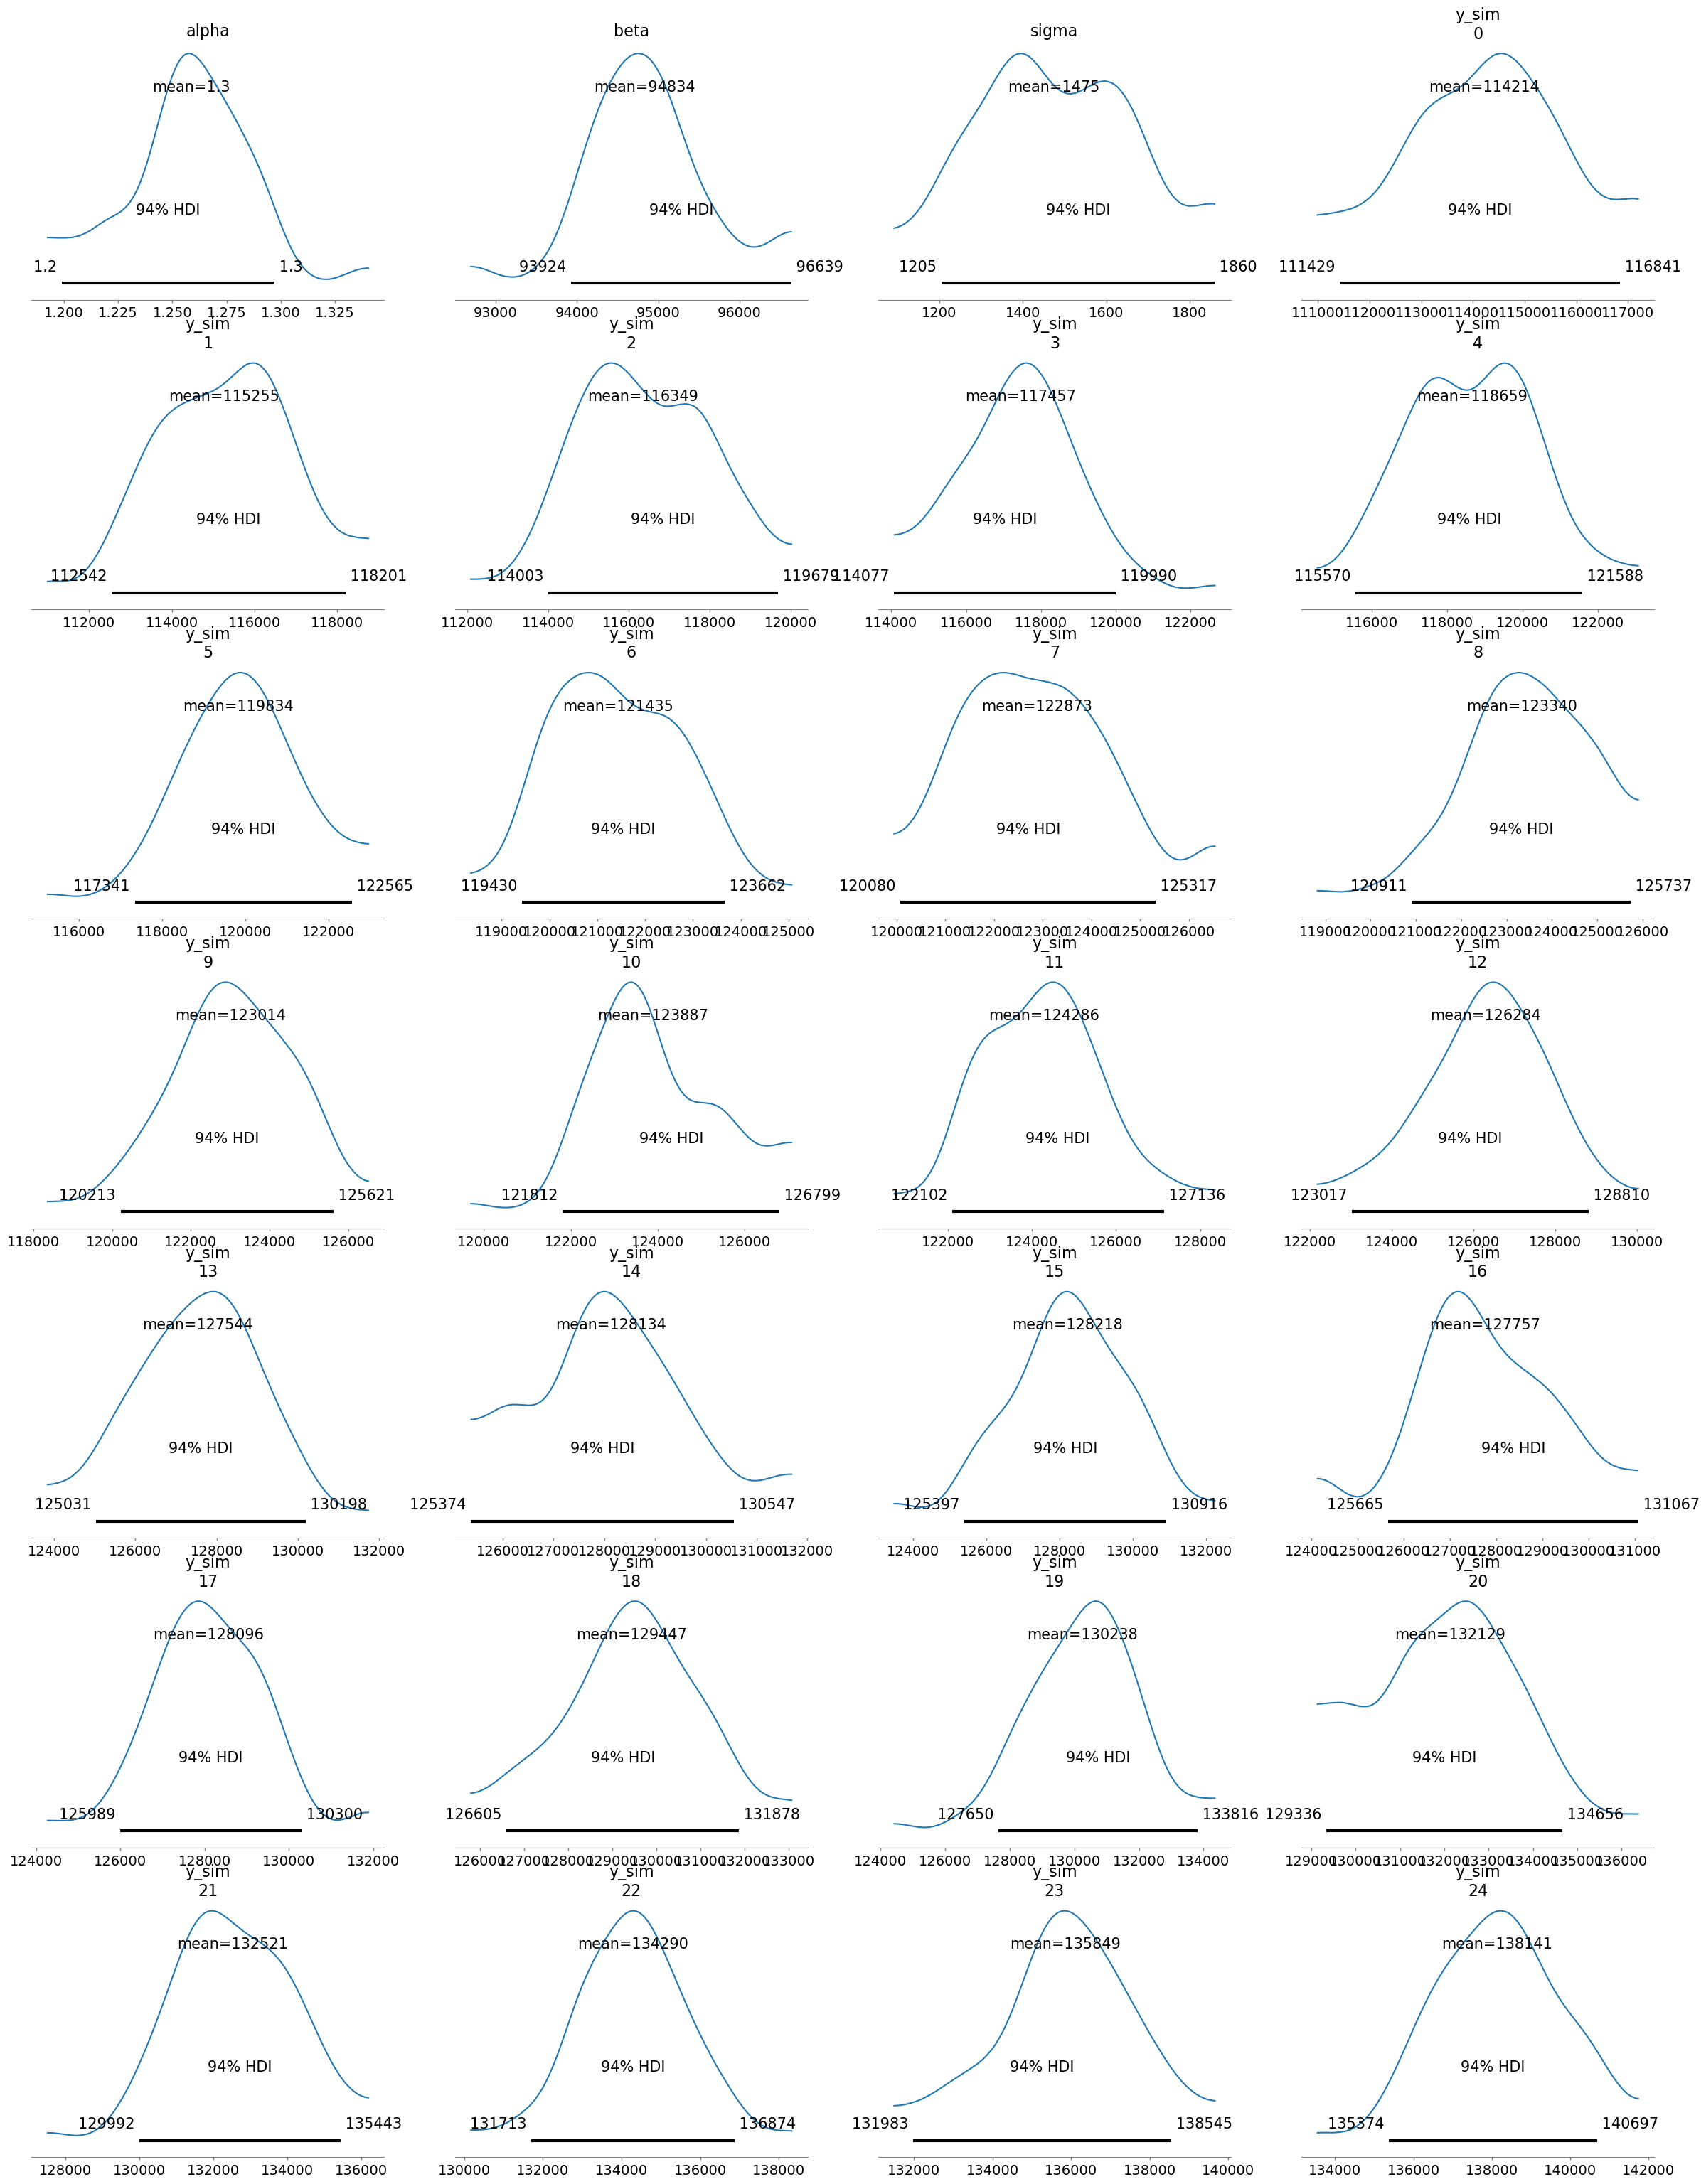

In [106]:
az.plot_posterior(post_1)
plt.show()

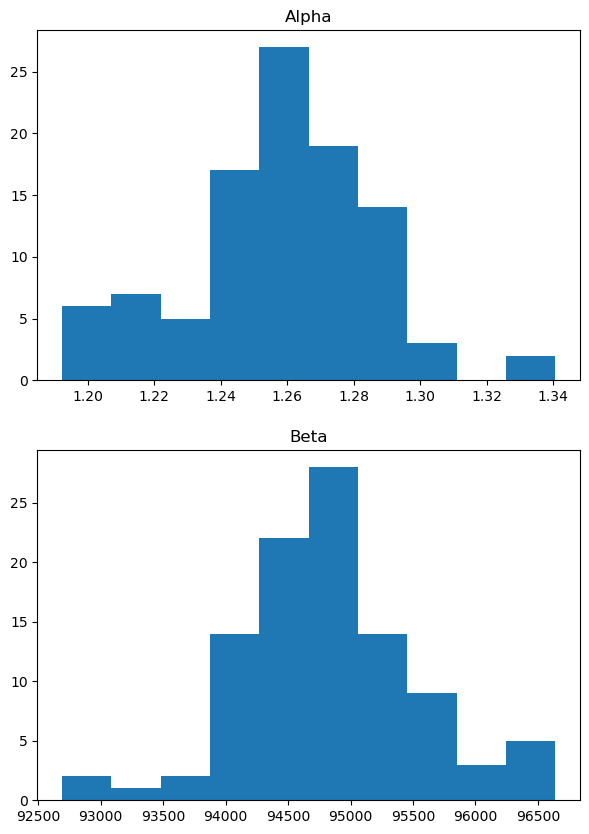

In [107]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.hist(post_1.alpha)
plt.title('Alpha')

plt.subplot(2,1,2)
plt.hist(post_1.beta)
plt.title('Beta')

plt.show()

### 6. Posterior (model 2) - analysis

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [108]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

13:59:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


13:59:30 - cmdstanpy - INFO - CmdStan done processing.


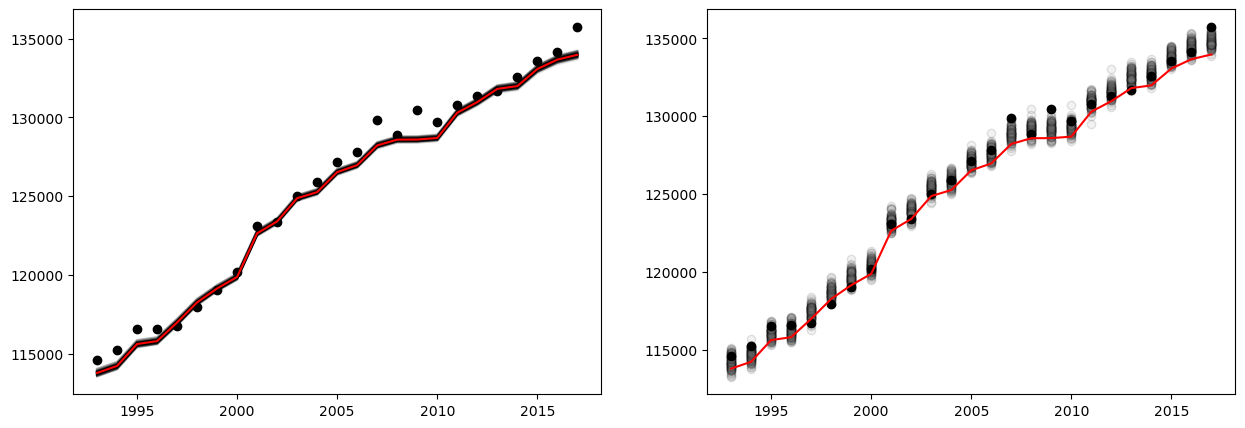

In [109]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], -post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [110]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-186.882000,0.157106,1.194850,-189.247000,-186.665000,-185.238000,57.8419,2313.68,0.990404
alpha_1,0.011887,0.000077,0.001078,0.010091,0.011835,0.013591,193.6880,7747.53,0.990812
alpha_2,0.810838,0.000637,0.004977,0.802282,0.810856,0.818748,61.1416,2445.66,1.027180
alpha_3,1280.870000,2.227390,17.825500,1250.960000,1280.510000,1315.880000,64.0459,2561.84,1.007400
beta,68477.500000,65.142000,601.628000,67504.200000,68467.900000,69541.600000,85.2969,3411.88,0.999612
sigma,359.547000,3.187090,25.656400,315.516000,356.895000,405.421000,64.8045,2592.18,1.017840
y_sim[1],114211.000000,35.665200,414.208000,113505.000000,114181.000000,114880.000000,134.8800,5395.20,0.991243
y_sim[2],114667.000000,31.935300,350.777000,114092.000000,114684.000000,115171.000000,120.6480,4825.92,1.000390
y_sim[3],116055.000000,32.570300,339.049000,115519.000000,116059.000000,116682.000000,108.3630,4334.51,0.991380
y_sim[4],116244.000000,40.341100,390.413000,115646.000000,116228.000000,117014.000000,93.6595,3746.38,1.011810


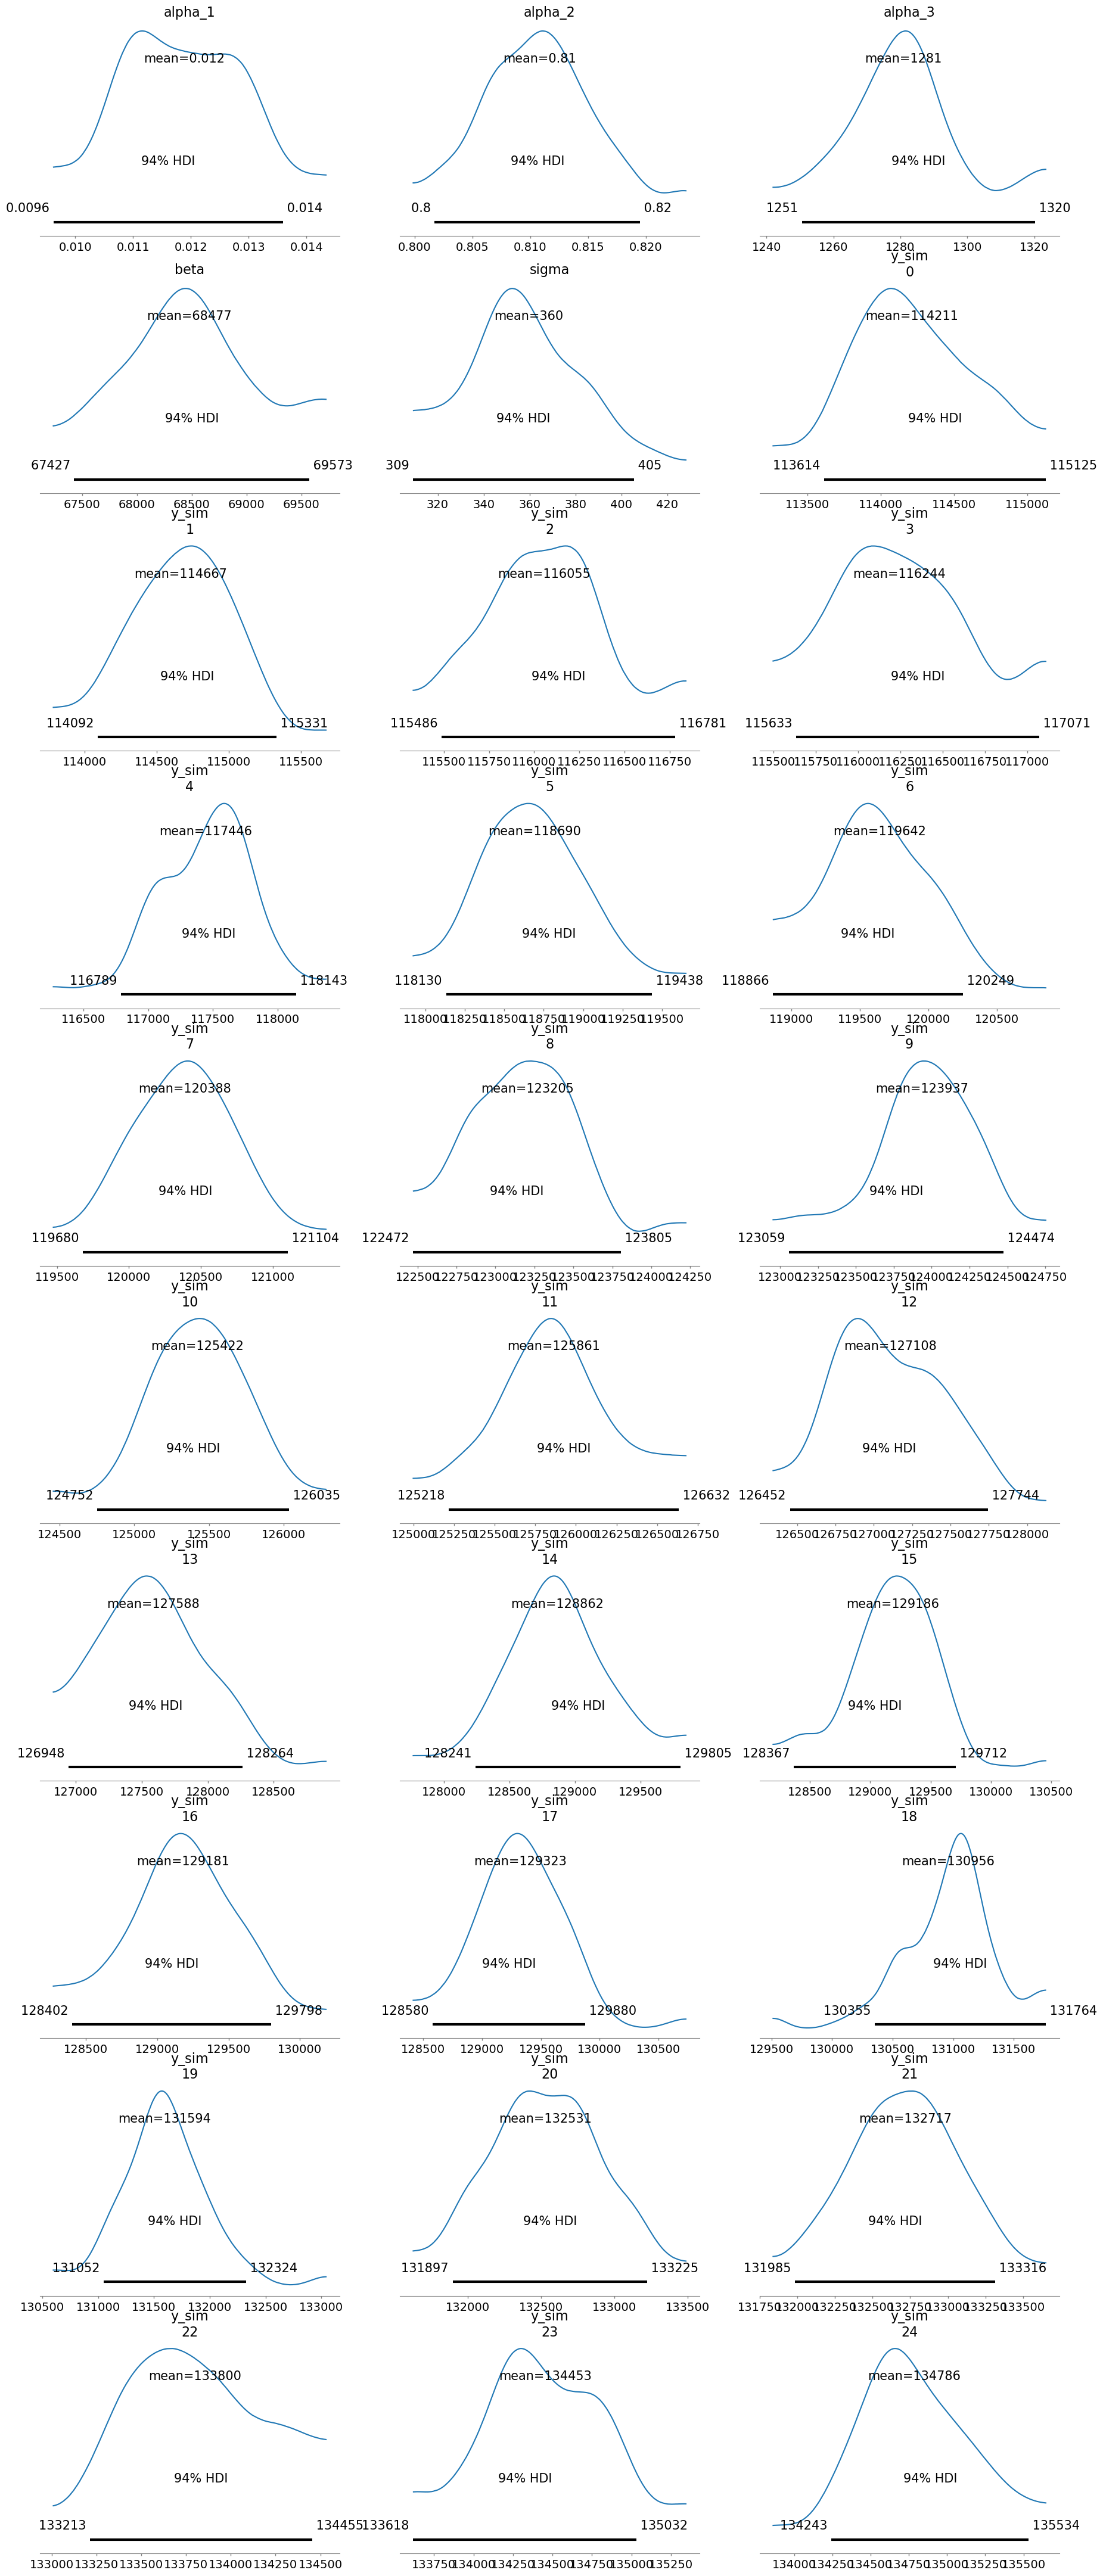

In [111]:
az.plot_posterior(post_2)
plt.show()

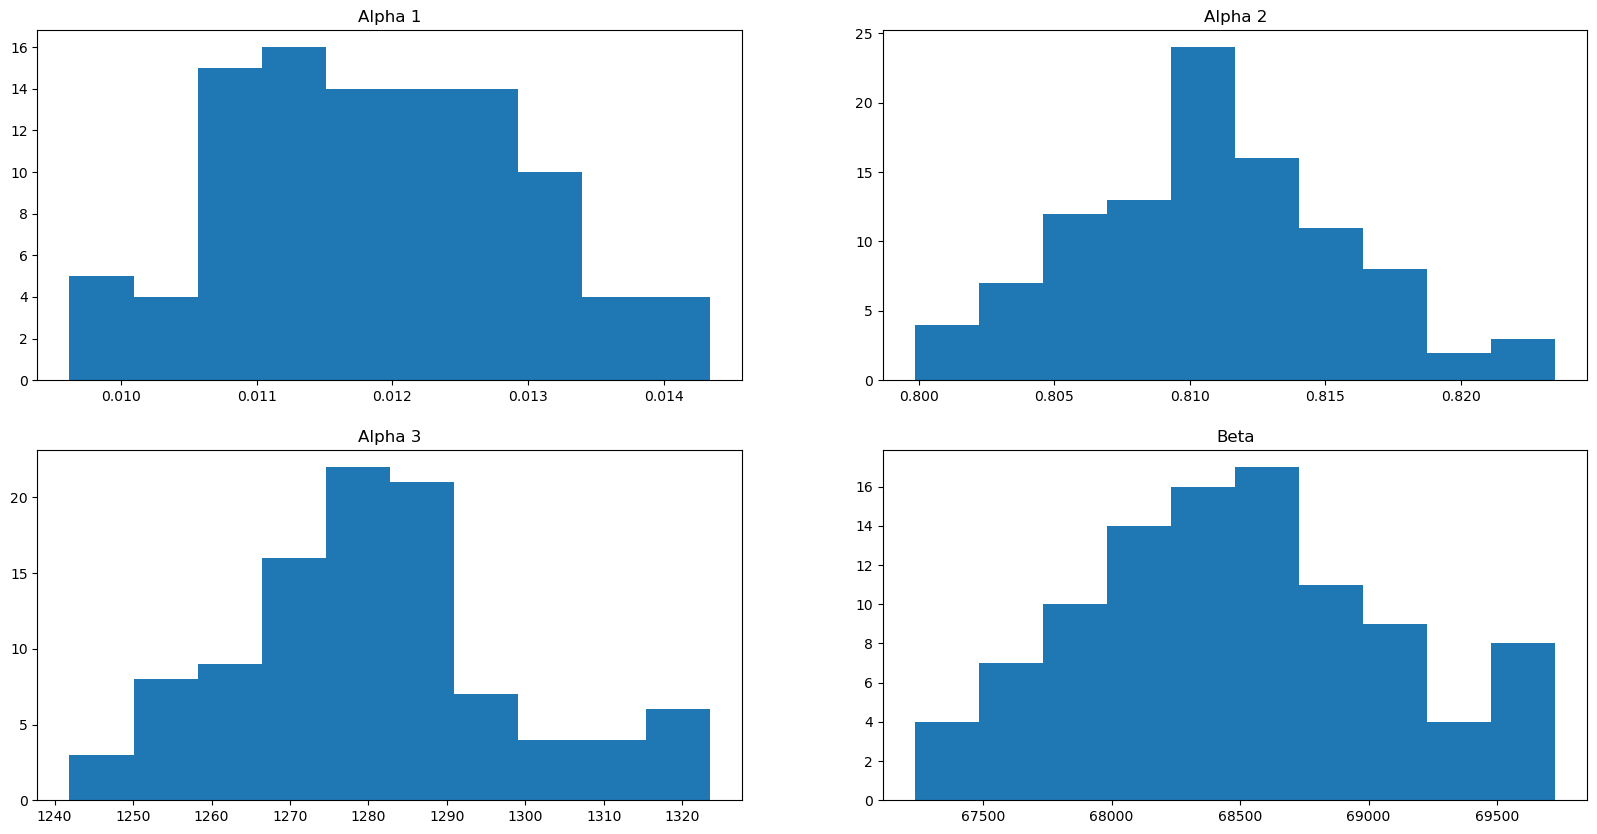

In [112]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(post_2.alpha_1)
plt.title('Alpha 1')

plt.subplot(2,2,2)
plt.hist(post_2.alpha_2)
plt.title('Alpha 2')

plt.subplot(2,2,3)
plt.hist(post_2.alpha_3)
plt.title('Alpha 3')

plt.subplot(2,2,4)
plt.hist(post_2.beta)
plt.title('Beta')

plt.show()

### 7. Model comparison

- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

The WAIC and LOO (information criteria) were used for model comparison, and both indicated that the more complex model achieves better results, which is also consistent with the level of fit of the plotted graph over the entire data range. However, if we consider only the subset of data that was not included in the model fitting process, the less complex model performs better.

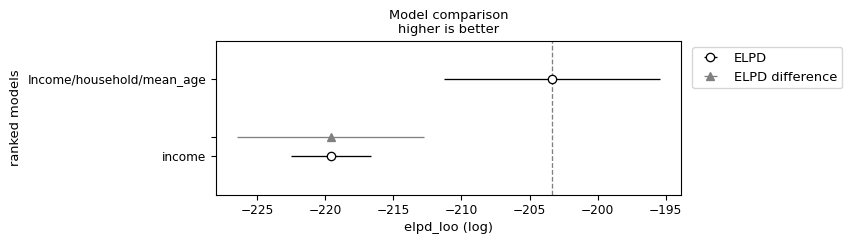

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-203.354767,4.317743,0.000000,0.875977,7.923691,0.000000,False,log
income,1,-219.599772,1.891485,16.245006,0.124023,2.937200,6.860741,False,log


In [113]:
# Compare the models using LOO
loo_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

In [114]:
az.loo(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -219.60     2.94
p_loo        1.89        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       24   96.0%
 (0.5, 0.7]   (ok)          1    4.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [115]:
az.loo(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -203.35     7.92
p_loo        4.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       25  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

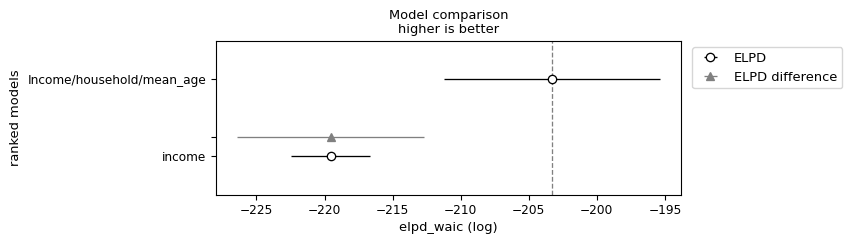

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-203.297111,4.260087,0.000000,0.876299,7.923558,0.000000,True,log
income,1,-219.551678,1.843390,16.254567,0.123701,2.925799,6.861424,True,log


In [116]:
# Compare the models using WAIC
waic_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare

In [117]:
az.waic(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -219.55     2.93
p_waic        1.84        -

There has been a warning during the calculation. Please check the results.

In [118]:
az.waic(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -203.30     7.92
p_waic        4.26        -

There has been a warning during the calculation. Please check the results.

For both criteria, the more complex model achieved a higher score, so it can be considered better than the simpler one.

In [119]:
data = {'N': 5, 'income': df_all['Income per member'][25:], 'y': df_all['Married'][25:]}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 5, 'income': df_all['Income per member'][25:], 'household': df_all['Household'][25:], 'mean_age': df_all['Mean age'][25:], 'y': df_all['Married'][25:]}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

13:59:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


13:59:35 - cmdstanpy - INFO - CmdStan done processing.
13:59:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed                       


13:59:36 - cmdstanpy - INFO - CmdStan done processing.


In [120]:
post_test_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-75.098400,0.163014,1.270020,-77.650400,-74.737700,-73.568500,60.6976,5058.13,0.994528
alpha_1,0.011976,0.000094,0.000941,0.010375,0.012030,0.013288,99.4277,8285.64,0.991730
alpha_2,0.808888,0.000660,0.006939,0.796967,0.809011,0.820691,110.6730,9222.77,1.008350
alpha_3,1280.620000,2.450570,16.983200,1256.260000,1280.620000,1307.960000,48.0293,4002.44,0.991786
beta,69298.100000,91.770400,915.520000,67564.300000,69320.100000,70604.000000,99.5247,8293.73,1.012760
sigma,427.669000,2.945170,21.680000,391.117000,431.236000,466.469000,54.1870,4515.59,0.990037
y_sim[1],136011.000000,56.698600,497.506000,135190.000000,136027.000000,136818.000000,76.9932,6416.10,1.040760
y_sim[2],136730.000000,46.088400,473.381000,135840.000000,136754.000000,137412.000000,105.4960,8791.37,0.990066
y_sim[3],136124.000000,41.213300,395.672000,135356.000000,136155.000000,136709.000000,92.1711,7680.92,0.993444
y_sim[4],136662.000000,52.099400,489.831000,135780.000000,136656.000000,137508.000000,88.3948,7366.24,0.993773


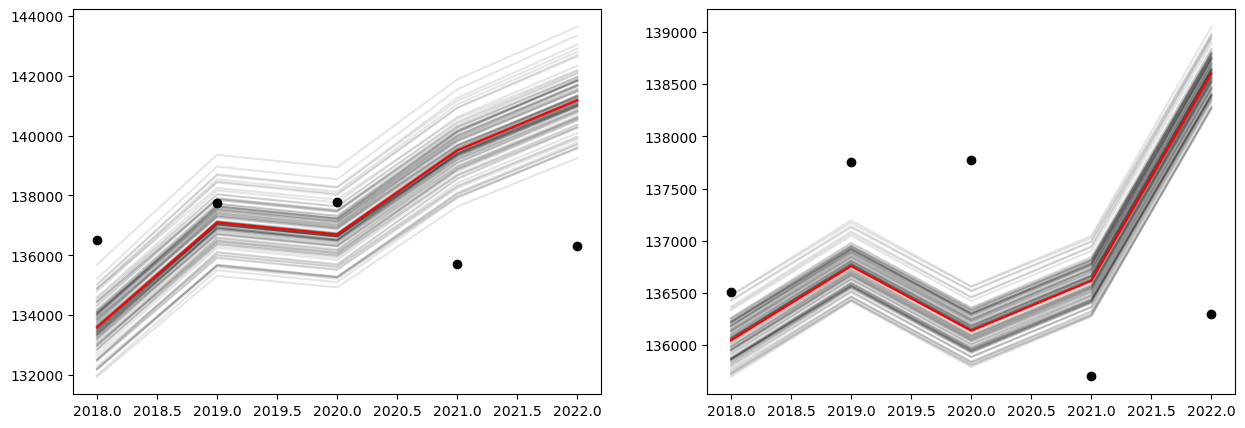

In [121]:
plt.figure(figsize=(15,5))

df_whole = df_all
df_all = df_all[25:]
plt.subplot(1,2,1)
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

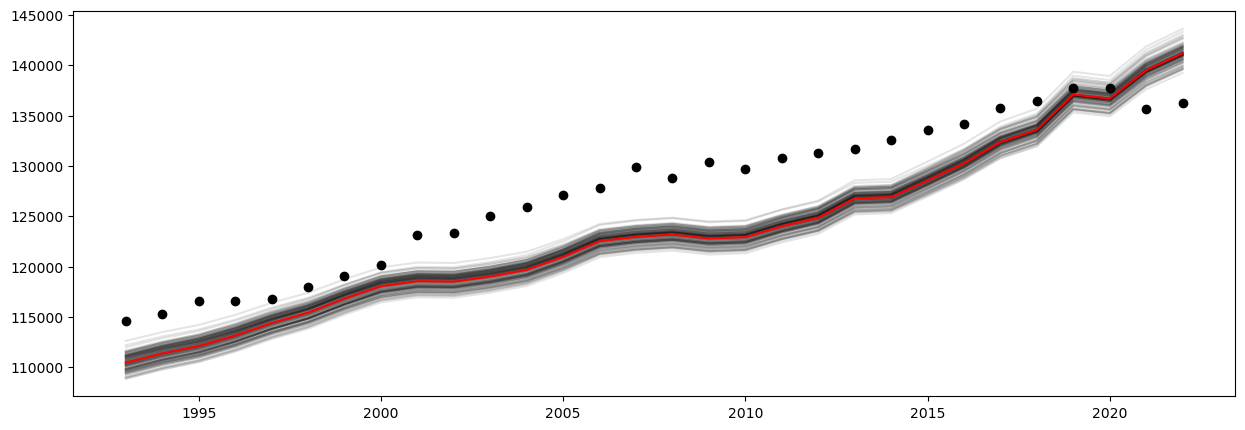

In [122]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

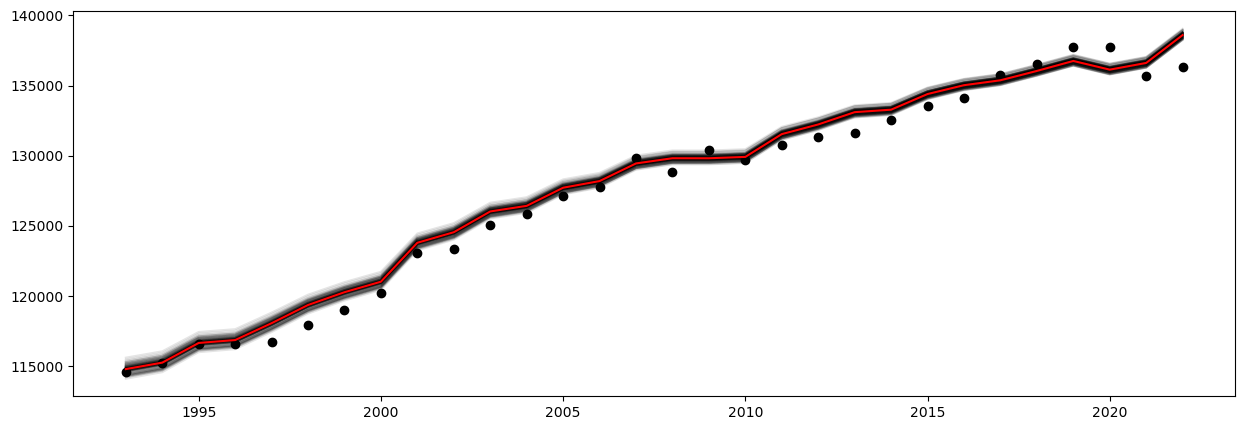

In [123]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()